<a href="https://colab.research.google.com/github/uvinduuu/EMLEC-24/blob/main/HS2_Part2_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Linear Probe


## Basics
In transfer learning, we use a model pre-trained on some large dataset. This is useful when our target dataset is small. This is common in fine-grained classification tasks (e.g. some specialized domain). Here, we will look at classifying dog species, which is a somewhat specialized task.

We focus on linear probing, where we only learn weights for a single linear layer (head) over some feature extractor backbone. In terms of the backbone, we will use a pre-trained model from a recent popular neural network architecture family, Vision Transformers (ViT). We select one of the smaller variants, ViT-tiny, for compute efficiency.


#### Linear Probing
Freeze the existing pre-trained model and only train a new linear layer w.r.t. our need.

In [1]:
import torch
import torchvision

! pip install timm==0.6.7
import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 5.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
! mkdir datasets
! ls

datasets  sample_data


In [3]:
# download the data

ds_train = torchvision.datasets.OxfordIIITPet(root="datasets", split="trainval", download=True)
ds_val = torchvision.datasets.OxfordIIITPet(root="datasets", split="test", download=True)

100%|██████████| 791918971/791918971 [00:31<00:00, 25457973.95it/s]


Extracting datasets/oxford-iiit-pet/images.tar.gz to datasets/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 11408529.11it/s]


Extracting datasets/oxford-iiit-pet/annotations.tar.gz to datasets/oxford-iiit-pet


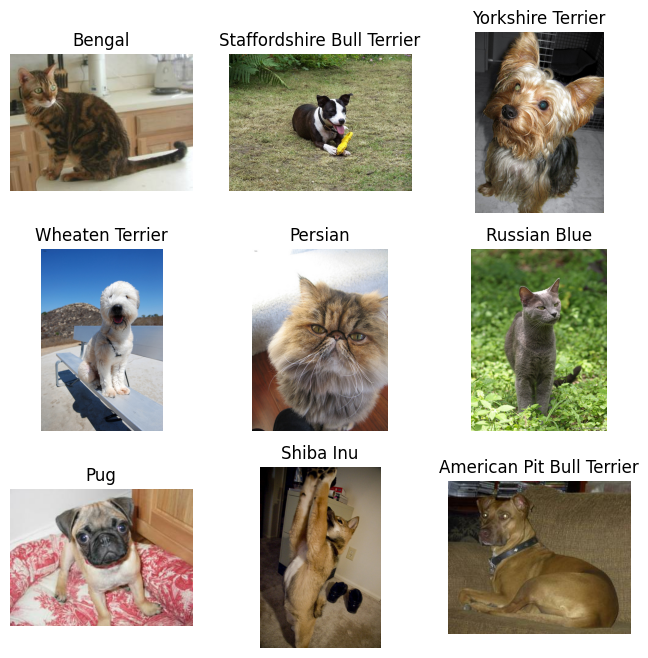

In [4]:
# let's first look at the data
from matplotlib import pyplot as plt
import numpy as np

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(ds_train), size=(1,)).item()
    img, label = ds_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(ds_train.classes[label])
    plt.axis("off")
    plt.imshow(np.array(img))
plt.show()

## CNNs, ViTs

Networks we use for image processing - they are both SOTA in various use cases!

In [5]:
# download pre-trained model
model = timm.models.vit_tiny_patch16_224(pretrained=True)

In [6]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
      (ls2): I

In [7]:
# output feature size of model
model.head.in_features

192

In [8]:
# classes in dataset
num_classes = len(ds_train.classes)
num_classes

37

The linear layer we learn over the ViT backbone should project features from 192-space to 37-space using a learnable weight matrix. We implement this as a PyTorch Linar Layer (which handled all learning components internally).

In [ ]:
model.head.weight.T.shape

torch.Size([192, 1000])

Here it outputs 1000 classes, but we just need only 37 classes, therefore have to modify.

In [9]:
# freeze backbone (we don't want to update backbone parameteres)
for param in model.parameters():
  param.requires_grad = False

# change linear head & set it to learn weights, keeping features same but change the output classes
model.head = torch.nn.Linear(in_features=model.head.in_features, out_features=num_classes)
for param in model.head.parameters():
  param.requires_grad = True

In [13]:
# let's create a dataloader - this converts raw images to fixed shaped matrices of data-type Tensor (that can store gradients).
# we also normalize out images - normalization of input is usually very important!

from torch.utils.data import DataLoader
from torchvision import transforms


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

ds_train = torchvision.datasets.OxfordIIITPet(root="datasets", split="trainval", download=True, transform=train_transform)
ds_val = torchvision.datasets.OxfordIIITPet(root="datasets", split="test", download=True, transform=test_transform)

train_dataloader = DataLoader(ds_train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(ds_val, batch_size=64, shuffle=False)

In [21]:
# move model to GPU
#model = model.cuda()

# loss function
loss_fn = torch.nn.CrossEntropyLoss()

# optimizer - SGD: stochastic gradient descent
lr = 1e-3
# Adam / AdamW - decoupled optimization (computation efficient) / LAMB (good large scale distributed training)
optim = torch.optim.AdamW(params=model.head.parameters(), lr=lr)

In [16]:
# train and test functions

def train_one_epoch(dataloader, model, loss_fn, optimizer, device="cpu", verbose=False):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose and batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:.3f}  [{current:>5d}/{size:>5d}]")

    return loss


def test_acc(dataloader, model, loss_fn, device="cpu", verbose=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    print(f"Running evaluation on {size} samples.")
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    if verbose:
      print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct


In [22]:
train_loss = train_one_epoch(train_dataloader, model, loss_fn, optim, verbose=True) # device= 'cuda'
print(f"Train loss after 1 epoch: {train_loss:.2f}")

loss: 3.703  [    0/ 3680]
loss: 2.940  [  640/ 3680]
loss: 2.202  [ 1280/ 3680]
loss: 1.847  [ 1920/ 3680]
loss: 1.781  [ 2560/ 3680]
loss: 1.337  [ 3200/ 3680]
Train loss after 1 epoch: 1.78


In [25]:
test_loss, acc = test_acc(test_dataloader, model, loss_fn , verbose=True) #,device="cuda"

Running evaluation on 3669 samples.
Test Error: 
 Accuracy: 56.0%, Avg loss: 1.509398 



We will train for 10 epochs to see how well the model gets. We can train for much longers to get better performance (left to students to try on their own).

In [ ]:
for epoch in range(10):
  train_loss = train_one_epoch(train_dataloader, model, loss_fn, optim, device="cuda", verbose=False)
  test_loss, acc = test_acc(test_dataloader, model, loss_fn, device="cuda", verbose=False)
  print(f"Train Loss @ {epoch} epochs: {train_loss:.3f}")
  print(f"Test Loss / Acc @ {epoch} epochs: {test_loss:.3f} / {(100*acc):.1f}")

Running evaluation on 3669 samples.
Train Loss @ 0 epochs: 1.259
Test Loss / Acc @ 0 epochs: 1.270 / 62.4
Running evaluation on 3669 samples.
Train Loss @ 1 epochs: 1.028
Test Loss / Acc @ 1 epochs: 1.129 / 65.5
Running evaluation on 3669 samples.
Train Loss @ 2 epochs: 0.869
Test Loss / Acc @ 2 epochs: 1.031 / 68.9
Running evaluation on 3669 samples.
Train Loss @ 3 epochs: 0.982
Test Loss / Acc @ 3 epochs: 0.974 / 70.7
Running evaluation on 3669 samples.
Train Loss @ 4 epochs: 0.494
Test Loss / Acc @ 4 epochs: 0.968 / 71.1
Running evaluation on 3669 samples.
Train Loss @ 5 epochs: 0.963
Test Loss / Acc @ 5 epochs: 0.930 / 72.0
Running evaluation on 3669 samples.
Train Loss @ 6 epochs: 0.708
Test Loss / Acc @ 6 epochs: 0.923 / 72.1
Running evaluation on 3669 samples.
Train Loss @ 7 epochs: 0.781
Test Loss / Acc @ 7 epochs: 0.914 / 72.0
Running evaluation on 3669 samples.
Train Loss @ 8 epochs: 0.464
Test Loss / Acc @ 8 epochs: 0.904 / 73.0
Running evaluation on 3669 samples.
Train Loss